In [4]:
!date

Fri Feb  2 00:13:38 EST 2018


In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.conv_learner import *
from planet import *
import operator
import os

In [7]:
project_name = 'planet-understanding-the-amazon-from-space'

In [8]:
PATH='/home/paperspace/data/planet/'
assert os.path.exists(PATH)

In [9]:
arch=resnet50
size=64
bs=64
metrics=[f2]

In [10]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [11]:
label_csv = f'{PATH}train_v2.csv'

In [12]:
no_of_rows = len(list(open(label_csv)))-1

In [13]:
val_idxs = get_cv_idxs(no_of_rows)

In [14]:
print(val_idxs.shape)
val_idxs

(8095,)


array([34602, 11243, 14499, ..., 13041, 22865, 25088])

In [15]:
label_df = pd.read_csv(label_csv)

In [16]:
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [17]:
label_df.pivot_table(index='tags', aggfunc=len).sort_values('image_name', ascending=False)[:10]

,image_name
tags,
clear primary,13636
partly_cloudy primary,3630
cloudy,2089
clear primary water,1850
agriculture clear primary road,1680
agriculture clear primary,1626
haze primary,1471
agriculture clear cultivation primary,1170
agriculture clear habitation primary road,1125


In [18]:
data = get_data(size)

In [19]:
x, y = next(iter(data.val_dl))

In [20]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [21]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

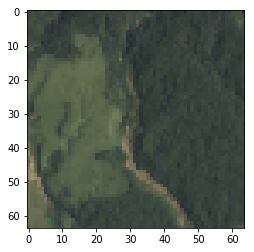

In [22]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

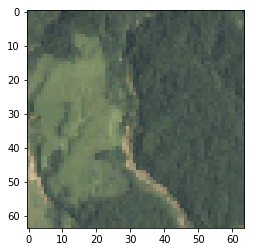

In [23]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] * 1.3 ) # TIP : Multiply by a value if the image is too hazy

In [24]:
data = get_data(size)

In [25]:
data = data.resize(int(size*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

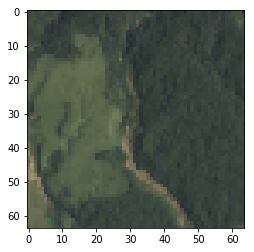

In [26]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

## Train model

In [27]:
learn = ConvLearner.pretrained(arch, data, metrics=metrics)

In [28]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.226086   0.306945   0.779355  



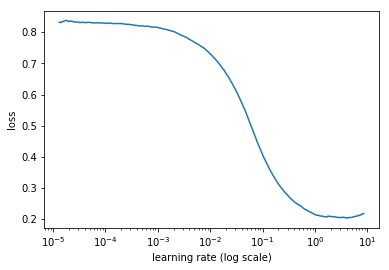

In [29]:
learn.sched.plot()

In [30]:
learning_rate = 0.2

In [31]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.146299   0.13354    0.883945  
    1      0.140126   0.128584   0.885972                    
    2      0.133078   0.126207   0.88931                     
    3      0.136921   0.12668    0.88916                     
    4      0.130888   0.124089   0.891783                    
    5      0.128472   0.122564   0.892834                    
    6      0.128685   0.12168    0.893404                    

CPU times: user 6min 28s, sys: 2min 2s, total: 8min 31s
Wall time: 5min 51s


[0.12168011, 0.8934037859009392]

##### As sat images are not part of imagnet, we divide by smaller numbers as we want to train the entire network from scratch. Well kind of, we initially use the weights from imagnet model as something is better than nothing and also, imagnet initial layers actually detect basic structures like edges etc.

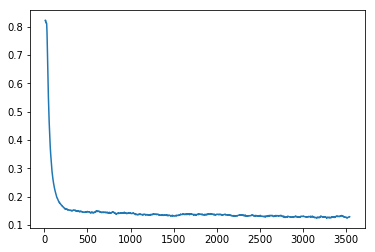

In [32]:
learn.sched.plot_loss()

In [33]:
learning_rates = np.array([learning_rate/9, learning_rate/3, learning_rate]) 

In [34]:
learn.unfreeze()

In [35]:
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.115951   0.105733   0.911312  
    1      0.115642   0.103503   0.911836                    
    2      0.10343    0.098625   0.917435                    
    3      0.111132   0.101309   0.913237                    
    4      0.102289   0.097642   0.918357                    
    5      0.096665   0.096534   0.919155                     
    6      0.092996   0.095331   0.919763                     

CPU times: user 11min 54s, sys: 4min 10s, total: 16min 4s
Wall time: 13min 32s


[0.095331036, 0.9197632023105476]

In [36]:
%time learn.save(f'{project_name}_last_layer_{size}')

CPU times: user 28 ms, sys: 100 ms, total: 128 ms
Wall time: 280 ms


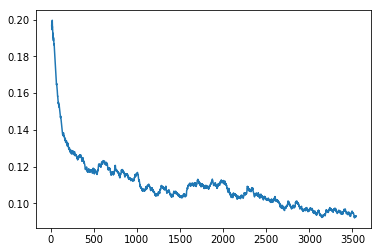

In [37]:
learn.sched.plot_loss()

### Increase pic size

In [38]:
size = 128

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.093425   0.092955   0.920275  
    1      0.092512   0.091084   0.923119                     
    2      0.092613   0.090286   0.92415                      
    3      0.090763   0.090089   0.923727                     
    4      0.09026    0.089942   0.924327                     
    5      0.090479   0.088989   0.924789                     
    6      0.087503   0.089169   0.925029                     

CPU times: user 22min 12s, sys: 3min 49s, total: 26min 1s
Wall time: 11min 44s


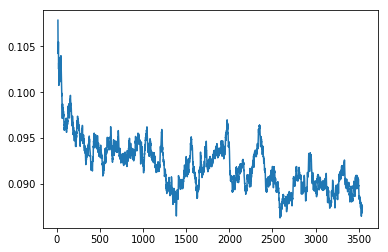

In [39]:
learn.set_data(get_data(size))
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.092348   0.087511   0.92737   
    1      0.097173   0.089628   0.926006                     
    2      0.087741   0.084573   0.930495                     
    3      0.099133   0.093811   0.92267                      
 76%|███████▌  | 383/506 [05:42<01:49,  1.12it/s, loss=0.0915]    4      0.087636   0.088837   0.925176  
    5      0.086067   0.084759   0.929118                     
    6      0.08297    0.083313   0.931701                     

CPU times: user 49min 8s, sys: 13min 54s, total: 1h 3min 3s
Wall time: 47min 30s


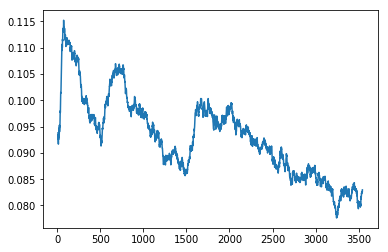

In [40]:
learn.unfreeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()
learn.save(f'{project_name}_last_layer_{size}')

In [3]:
size = 256

In [4]:
learn.set_data(get_data(size))
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()

NameError: name 'learn' is not defined

In [ ]:
learn.unfreeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()
learn.save(f'{project_name}_last_layer_{size}')

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
print(multi_preds.shape)
print(preds.shape)
print(y.shape)

In [ ]:
preds[0]

In [ ]:
y[0]

In [ ]:
f2(preds,y)

In [ ]:
test_multi_preds, test_y = learn.TTA(is_test=True) # doesn't return test_y for test set as the label is to be predicted!
test_preds = np.mean(test_multi_preds, 0)

In [ ]:
print(test_multi_preds.shape)
print(test_preds.shape)
print(test_y.shape)

In [ ]:
test_y.max()

In [ ]:
test_preds[0]

In [ ]:
test_preds[240]

In [ ]:
test_probs = np.round(test_preds)

In [ ]:
test_probs.shape

In [ ]:
test_probs[0]

In [ ]:
print(test_probs[240]) # all zeros?

In [ ]:
f2(test_preds, test_probs)

In [ ]:
#def get_test_classes(probs, classes):
#    prob_idxs = np.argwhere(probs==1) # Indexs of 1's in every row of probs ([0 1 0 1 0 1 0])
#    prob_idxs = prob_idxs.flatten().tolist() # Convert the o/p to a list after flatting it as required by itemgetter
    #return operator.itemgetter(*prob_idxs)(classes) 

In [ ]:
def get_test_classes(probs, classes):
    prob_idxs = np.argwhere(probs==1) # Indexs of 1's in every row of probs ([0 1 0 1 0 1 0])
    prob_idxs = prob_idxs.flatten().tolist() # Convert the o/p to a list after flatting it as required by itemgetter

    all_probs_zero = 0
    if not prob_idxs:
        all_probs_zero =+ 1
        prob_idxs = [10]  # default to haze

    if all_probs_zero != 0: print("All 0 probs : {}".format(all_probs_zero))
    #return operator.itemgetter(*(np.argwhere(probs==1)).flatten().tolist())(classes)    

    classes = operator.itemgetter(*prob_idxs)(classes)
    # If there is just one class, then the itemgetter returns a string instead of a tuple
    # Convert to tuple. Else, the join will put a space in between every letter in the aingle word.
    # E.g.: c l o u d y instead of cludy
    if type(classes) == str: classes = (classes,) 
        
    return classes

In [ ]:
a = get_test_classes(test_probs[4], learn.data.classes)
print(type(a))
print(len(a))
a

In [ ]:
#operator.itemgetter(a)(learn.data.classes) 
#test_classes = [' '.join( get_test_classes(probs, learn.data.classes) ) for probs in test_probs]
#[print( ' '.join( operator.itemgetter(*(np.argwhere(a==1)).flatten().tolist())(learn.data.classes) ) ) for a in test_probs[230:250]]
#test_classes = [' '.join( operator.itemgetter(*(np.argwhere(a==1)).flatten().tolist())(learn.data.classes) )  for a in test_probs]

In [ ]:

test_classes = [ ' '.join( get_test_classes(probs, learn.data.classes) ) for probs in test_probs]


In [ ]:
test_classes[:5]
#print(len(test_classes))

In [ ]:
fn = PATH + get_data(224).test_ds.fnames[240]
fn

In [ ]:
fnames = [f[9:-4] for f in learn.data.test_ds.fnames]
len(fnames)

In [ ]:
fnames[240]

In [ ]:
subm = np.stack([fnames, test_classes], axis=1)
subm[:5]

In [ ]:
test_df = pd.DataFrame(subm)

In [ ]:
test_df.head()

In [ ]:
#test_df.insert(0, 'image_name', fnames )

# Submit to kaggle

In [ ]:
!pwd

In [ ]:
now = datetime.datetime.now()
submission_file_name = f'{project_name}-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, subm, fmt='%s,%s', header='image_name,tags', comments='')

In [ ]:
from IPython.display import FileLink
FileLink(submission_file_name)

In [ ]:
!date